In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import numpy as np
from scipy.spatial import cKDTree
from sklearn.neighbors import KDTree, BallTree

In [4]:
# Uniform random distribution
uniform_N = np.random.random((10000, 4))
uniform_D = np.random.random((1797, 128))

In [5]:
# Digits distribution
from sklearn.datasets import load_digits
digits = load_digits()

print digits.images.shape

(1797, 8, 8)


In [6]:
# We need more than 1797 digits, so let's stack the central
# regions of the images to inflate the dataset.
digits_N = np.vstack([digits.images[:, 2:4, 2:4],
                      digits.images[:, 2:4, 4:6],
                      digits.images[:, 4:6, 2:4],
                      digits.images[:, 4:6, 4:6],
                      digits.images[:, 4:6, 5:7],
                      digits.images[:, 5:7, 4:6]])
digits_N = digits_N.reshape((-1, 4))[:10000]

# For the dimensionality test, we need up to 128 dimesnions, so
# we'll combine some of the images.
digits_D = np.hstack((digits.data,
                      np.vstack((digits.data[:1000], digits.data[1000:]))))
# The edge pixels are all basically zero.  For the dimensionality tests
# to be reasonable, we want the low-dimension case to probe interir pixels
digits_D = np.hstack([digits_D[:, 28:], digits_D[:, :28]])

In [7]:
# The spectra can be downloaded with astroML: see http://www.astroML.org
from astroML.datasets import fetch_sdss_corrected_spectra
spectra = fetch_sdss_corrected_spectra()['spectra']
spectra.shape

(4000, 1000)

In [8]:
# Take sections of spectra and stack them to reach N=10000 samples
spectra_N = np.vstack([spectra[:, 500:504],
                       spectra[:, 504:508],
                       spectra[:2000, 508:512]])
# Take a central region of the spectra for the dimensionality study
spectra_D = spectra[:1797, 400:528]

In [9]:
print uniform_N.shape, uniform_D.shape
print digits_N.shape, digits_D.shape
print spectra_N.shape, spectra_D.shape

(10000, 4) (1797, 128)
(10000, 4) (1797, 128)
(10000, 4) (1797, 128)


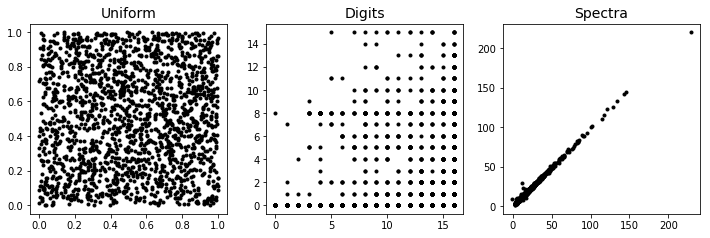

In [10]:
titles = ['Uniform', 'Digits', 'Spectra']
datasets_D = [uniform_D, digits_D, spectra_D]
datasets_N = [uniform_N, digits_N, spectra_N]

fig, ax = plt.subplots(1, 3, figsize=(12, 3.5))

for axi, title, dataset in zip(ax, titles, datasets_D):
    axi.plot(dataset[:, 1], dataset[:, 2], '.k')
    axi.set_title(title, size=14)

In [11]:
from time import time

def average_time(executable, *args, **kwargs):
    """Compute the average time over N runs"""
    N = 10
    t = 0
    for i in range(N):
        t0 = time()
        res = executable(*args, **kwargs)
        t1 = time()
        t += (t1 - t0)
    return res, t * 1. / N

In [12]:
TREE_DICT = dict(cKDTree=cKDTree, KDTree=KDTree, BallTree=BallTree)
colors = dict(cKDTree='green', KDTree='red', BallTree='blue', brute='gray', gaussian_kde='black')

def bench_knn_query(tree_name, X, N, D, leaf_size, k,
                    build_args=None, query_args=None):
    """Run benchmarks for the k-nearest neighbors query"""
    Tree = TREE_DICT[tree_name]
    
    if build_args is None:
        build_args = {}
        
    if query_args is None:
        query_args = {}
        
    NDLk = np.broadcast(N, D, leaf_size, k)
        
    t_build = np.zeros(NDLk.size)
    t_query = np.zeros(NDLk.size)
    
    for i, (N, D, leaf_size, k) in enumerate(NDLk):
        XND = X[:N, :D]
        
        if tree_name == 'cKDTree':
            build_args['leafsize'] = leaf_size
        else:
            build_args['leaf_size'] = leaf_size
        
        tree, t_build[i] = average_time(Tree, XND, **build_args)
        res, t_query[i] = average_time(tree.query, XND, k, **query_args)
        
    return t_build, t_query

In [13]:
def plot_scaling(data, estimate_brute=False, suptitle='', **kwargs):
    """Plot the scaling comparisons for different tree types"""
    # Find the iterable key
    iterables = [key for (key, val) in kwargs.iteritems() if hasattr(val, '__len__')]
    if len(iterables) != 1:
        raise ValueError("A single iterable argument must be specified")
    x_key = iterables[0]
    x = kwargs[x_key]
    
    # Set some defaults
    if 'N' not in kwargs:
        kwargs['N'] = data.shape[0]
    if 'D' not in kwargs:
        kwargs['D'] = data.shape[1]
    if 'leaf_size' not in kwargs:
        kwargs['leaf_size'] = 15
    if 'k' not in kwargs:
        kwargs['k'] = 5
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 4),
                           subplot_kw=dict(yscale='log', xscale='log'))
        
    for tree_name in ['cKDTree', 'KDTree', 'BallTree']:
        t_build, t_query = bench_knn_query(tree_name, data, **kwargs)
        ax[0].plot(x, t_build, color=colors[tree_name], label=tree_name)
        ax[1].plot(x, t_query, color=colors[tree_name], label=tree_name)
        
        if tree_name != 'cKDTree':
            t_build, t_query = bench_knn_query(tree_name, data,
                                               query_args=dict(breadth_first=True, dualtree=True),
                                               **kwargs)
            ax[0].plot(x, t_build, color=colors[tree_name], linestyle='--')
            ax[1].plot(x, t_query, color=colors[tree_name], linestyle='--')
            
    if estimate_brute:
        Nmin = np.min(kwargs['N'])
        Dmin = np.min(kwargs['D'])
        kmin = np.min(kwargs['k'])
        
        # get a baseline brute force time by setting the leaf size large,
        # ensuring a brute force calculation over the data
        _, t0 = bench_knn_query('KDTree', data, N=Nmin, D=Dmin, leaf_size=2 * Nmin, k=kmin)
        
        # use the theoretical scaling: O[N^2 D]
        if x_key == 'N':
            exponent = 2
        elif x_key == 'D':
            exponent = 1
        else:
            exponent = 0
            
        t_brute = t0 * (np.array(x, dtype=float) / np.min(x)) ** exponent
        ax[1].plot(x, t_brute, color=colors['brute'], label='brute force (est.)')
            
    for axi in ax:
        axi.grid(True)
        if x_key == 'leaf_size':
            x_key = 'Leaf size'
        axi.set_xlabel(x_key)
        axi.set_ylabel('time (s)')
        axi.legend(loc='upper left')
        axi.set_xlim(np.min(x), np.max(x))
        
    info_str = ', '.join([key + '={' + key + '}' for key in ['N', 'D', 'k'] if key != x_key])
    ax[0].set_title('Tree Build Time ({0})'.format(info_str.format(**kwargs)))
    ax[1].set_title('Tree Query Time ({0})'.format(info_str.format(**kwargs)))
    
    if suptitle:
        fig.suptitle(suptitle, size=16)
    
    return fig, ax

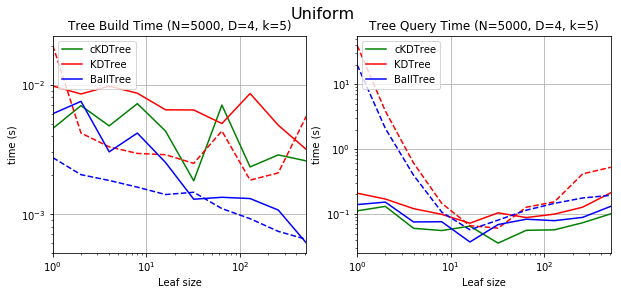

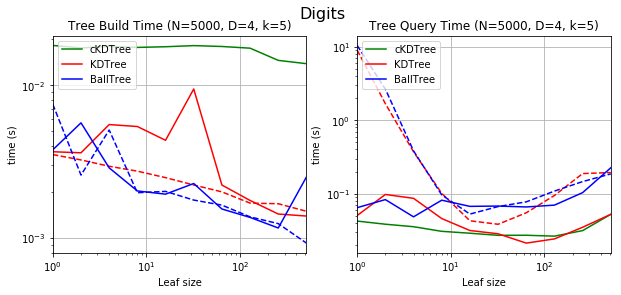

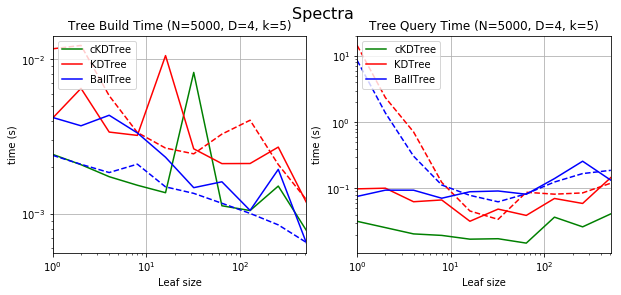

In [14]:
leaf_size = 2 ** np.arange(10)
for title, dataset in zip(titles, datasets_N):
    fig, ax = plot_scaling(dataset, N=5000, leaf_size=leaf_size, suptitle=title)